In [1]:
%matplotlib inline

In [2]:
from mne_bids import BIDSPath
from pipeline import Pipeline
from preprocessing import *
from erpanalysis import ERPAnalysis
import os

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

In [4]:
pip = Pipeline(bids_path)

In [5]:


pip.load_data()
pip.set_montage()
pip.apply_cleaning(CleaningData(bids_path))
pip.apply_filter(SimpleMNEFilter(0.1, 50, 'firwin'))
pip.apply_ica(PrecomputedICA(bids_path))

pip.apply_resampling(512)
pip.apply_rereferencing('average')
# pip.apply_ica(SimpleMNEICA('fastica', exclude=[0,1, 2]))

INFO:root:Loading Data
INFO:root:Setting montage
INFO:root:Applying cleaning
/Users/ssaurabh/Projects/eeg-pipeline/preprocessing.py:95: UserWarning: loadtxt: Empty input file: "data/P3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_badChannels.tsv"
  bad_channels = np.loadtxt(ch_fname, delimiter='\t', dtype='int')
INFO:root:Applying filtering
INFO:root:Applying ICA
INFO:root:Applying resampling
INFO:root:Applying re-referencing


In [6]:
erp = ERPAnalysis(-0.1, 0.8)
df = pip.compute_erp_peak(erp, 'stimulus', 0.450, 0.150, ['Cz'])

INFO:root:Trial 0: peak of 15 µV and mean of 2 µV at 328 ms in channel Cz
INFO:root:Trial 1: peak of 8 µV and mean of -6 µV at 324 ms in channel Cz
INFO:root:Trial 2: peak of 2 µV and mean of -20 µV at 342 ms in channel Cz
INFO:root:Trial 3: peak of 69 µV and mean of 35 µV at 580 ms in channel Cz
INFO:root:Trial 4: peak of 14 µV and mean of -9 µV at 561 ms in channel Cz
INFO:root:Trial 5: peak of 17 µV and mean of -9 µV at 582 ms in channel Cz
INFO:root:Trial 6: peak of 12 µV and mean of -4 µV at 502 ms in channel Cz
INFO:root:Trial 7: peak of 11 µV and mean of 1 µV at 469 ms in channel Cz
INFO:root:Trial 8: peak of 44 µV and mean of 28 µV at 590 ms in channel Cz
INFO:root:Trial 9: peak of -17 µV and mean of -34 µV at 307 ms in channel Cz
INFO:root:Trial 10: peak of -17 µV and mean of -47 µV at 314 ms in channel Cz
INFO:root:Trial 11: peak of -38 µV and mean of -73 µV at 596 ms in channel Cz
INFO:root:Trial 12: peak of 37 µV and mean of 3 µV at 566 ms in channel Cz
INFO:root:Trial 13: 

In [7]:
df.describe()

,peak_amp,mean_amp,latency,trial
count,91.000000,91.000000,91.000000,91.00000
mean,39.494505,7.989011,450.285714,45.00000
std,102.980297,88.815476,104.473951,26.41338
min,-315.000000,-386.000000,301.000000,0.00000
25%,6.500000,-15.000000,354.000000,22.50000
50%,22.000000,-2.000000,438.000000,45.00000
75%,44.000000,18.000000,562.000000,67.50000
max,642.000000,485.000000,598.000000,90.00000


In [8]:
# df[df['channel'] == 'Cz']

In [9]:
blocks = np.array([ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)])
rare = np.array([ x + i for i, x in enumerate(range(11, 56, 10))]).tolist()
freq = np.setdiff1d(blocks.flatten(), rare).tolist()

In [10]:
pip.event_ids.keys() 

dict_keys(['response/201', 'response/202', 'stimulus/11', 'stimulus/12', 'stimulus/13', 'stimulus/14', 'stimulus/15', 'stimulus/21', 'stimulus/22', 'stimulus/23', 'stimulus/24', 'stimulus/25', 'stimulus/31', 'stimulus/32', 'stimulus/33', 'stimulus/34', 'stimulus/35', 'stimulus/41', 'stimulus/42', 'stimulus/43', 'stimulus/44', 'stimulus/45', 'stimulus/51', 'stimulus/52', 'stimulus/53', 'stimulus/54', 'stimulus/55'])

In [11]:
rare = ['stimulus/' + str(i) for i in rare]
freq = ['stimulus/' + str(i) for i in freq]

In [12]:
rare_dict = dict((k, pip.event_ids[k]) for k in rare)
freq_dict = dict((k, pip.event_ids[k]) for k in freq)

In [13]:
rare_epochs = mne.Epochs(pip.raw,pip.events, rare_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
freq_epochs = mne.Epochs(pip.raw,pip.events, freq_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()


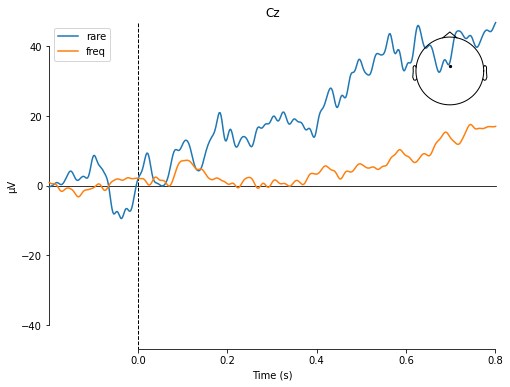

[<Figure size 576x432 with 2 Axes>]

In [14]:
mne.viz.plot_compare_evokeds({'rare': rare_epochs.average(), 'freq': freq_epochs.average()}, picks='Cz')

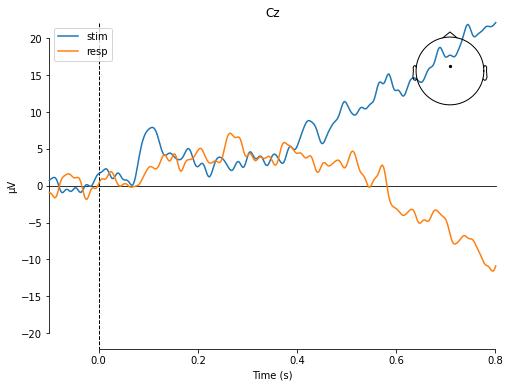

[<Figure size 576x432 with 2 Axes>]

In [15]:
_epochs = mne.Epochs(pip.raw, pip.events, pip.event_ids, tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()
mne.viz.plot_compare_evokeds({'stim': _epochs['stimulus'].average(), 'resp': _epochs['response'].average()}, picks='Cz')

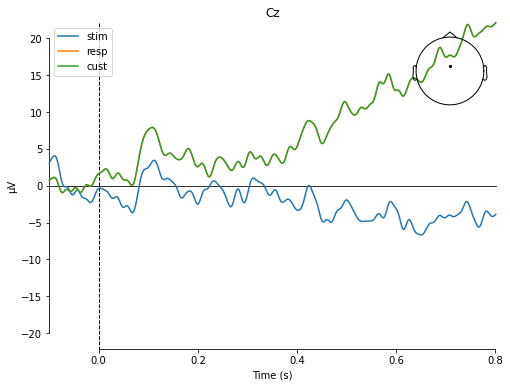

[<Figure size 576x432 with 2 Axes>]

In [16]:
wanted_keys = [e for e in pip.event_ids.keys() if "stimulus" in e]
evts_dict_stim=dict((k, pip.event_ids[k]) for k in wanted_keys if k in pip.event_ids)

# get epochs with and without rejection
epochs = mne.Epochs(pip.raw, pip.events, evts_dict_stim,tmin=-0.1,tmax=0.8)
mne.viz.plot_compare_evokeds({'stim': epochs['stimulus'].average(), 'resp': erp.epochs['stimulus'].average(), 'cust': _epochs['stimulus'].average()}, picks='Cz')